##  `backward()` and `torch.autograd.grad()`

In PyTorch, both `backward()` and `torch.autograd.grad()` are used for computing gradients

### `backward()`

- Computes gradients for a scalar output (typically a loss function) with respect to input tensors that have `requires_grad=True`.

- Gradients are **accumulated** into the `.grad` attribute of each tensor involved.

- When to use it? 
  -  Commonly used in training loops to compute gradients of a loss function with respect to model parameters.

- **Usage**: Called on a scalar tensor:
  ```python
  loss.backward()

### `torch.autograd.grad()`

-  Computes and returns gradients of outputs with respect to inputs without accumulating them in `.grad` attributes. This provides more fine-grained control over the gradient computation process.

- The function returns gradients directly and does not modify or accumulate them in the `.grad` attributes of the input tensors.

- When to use it? 
  - Useful for custom gradient calculations.
  - Suitable for computing gradients for non-scalar outputs.
  - Ideal when you don't want to accumulate gradients, such as in specific analyses or custom implementations outside typical training loops.

- **Usage**: Specify `outputs`, `inputs`, and (optionally) `grad_outputs`:
  ```python
  grads = torch.autograd.grad(outputs, inputs, grad_outputs)


**Note** 
  - We only do first-order derivatives for the loss functions.
    - For higher-order derivatives (ex: second-derivative), we need to set 'create_graph = True'. We can ignore this parameter as we are only doing first-order derivatives.
  - We don't accumulate the gradients across iterations 
    - If gradients need to be accumulated across different passes, we need to set 'retain_graph=True'. We can ignore this parameter as well.

Reference:
- https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
- https://pytorch.org/docs/stable/generated/torch.autograd.grad.html
- https://www.geeksforgeeks.org/understanding-pytorchs-autogradgrad-and-autogradbackward/?ref=oin_asr1   
  - provides a very good summary of both methods

# Understanding autodifferentiation in pytorch

Autograd in PyTorch performs numerical differentiation, i.e., it calculates the derivative at a specific value of the variable. It won't provide closed-form expression.

## Example: 1

$$f(x,y) = x^2 + 3xy + y^2$$

$$\frac{\partial f(x,y)}{\partial x} = 2x+3y$$

$$\frac{\partial f(x,y)}{\partial y} = 3x+2y$$

Derivatives at $x = 2$ and $y = 3$:

$$\frac{\partial f(x,y)}{\partial x} = 2*2+3*3 = 13$$

$$\frac{\partial f(x,y)}{\partial y} = 3*2+2*3 = 12$$

We can access the specific value of the gradient with respect to the parameter with the attribute .grad()


In [1]:
import torch
import matplotlib.pyplot as plt

# Define the variables with requires_grad=True to track computations
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# Define the function
f = x**2 + 3*x*y + y**2

# Compute the gradients
f.backward()  #retain_graph=True

# Output the gradients df/dx and df/dy
print(f"Gradient of f with respect to x: {x.grad}")
print(f"Gradient of f with respect to y: {y.grad}")


# Notice the accumulation of gradients

# Zero gradients
#x.grad.zero_()
#y.grad.zero_()

x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(4.0, requires_grad=True)
# Define the function
f = x**2 + 3*x*y + y**2

# Compute the gradients
f.backward()

# Output the gradients df/dx and df/dy
print(f"Gradient of f with respect to x: {x.grad}")
print(f"Gradient of f with respect to y: {y.grad}")

Gradient of f with respect to x: 13.0
Gradient of f with respect to y: 12.0
Gradient of f with respect to x: 18.0
Gradient of f with respect to y: 17.0


## Derivative of the Norm of a Vector

For a vector $\mathbf{w} = \begin{bmatrix}w_0\\ w_1\end{bmatrix}$, the norm is defined as:

$$ f(\mathbf{w}) = \|\mathbf{w}\| = \sqrt{w_0^2 + w_1^2} $$

The gradient vector of the norm with respect to $\mathbf{w}$ is:

$$ \nabla f(\mathbf{w}) = \begin{bmatrix}\frac{\partial f}{\partial w_0} \\ \frac{\partial f}{\partial w_1} \end{bmatrix} $$

Using the chain rule, the derivatives are:

 $$\frac{\partial f}{\partial w_0} = \frac{w_0}{\sqrt{w_0^2 + w_1^2}}$$
 $$\frac{\partial f}{\partial w_1} = \frac{w_1}{\sqrt{w_0^2 + w_1^2}}$$

Thus, the gradient vector is:

$$ \nabla f(\mathbf{w}) = \frac{1}{\sqrt{w_0^2 + w_1^2}} \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} = \frac{w}{\|w\|}$$

This expression shows how the norm changes with respect to each component of $\mathbf{w}$.



In [2]:
# Define the variables
w = torch.tensor([1.0, 2.0], requires_grad=True)

# Define the function (norm of the vector)
f = torch.norm(w)

# Compute the gradients
f.backward()

# Output the gradient vector
print(f"Gradient vector: {w.grad}")


# Verifying the answer
norm_value = torch.norm(w).item()

closed_form_grad = w / norm_value
# Output the closed-form gradient

print(f"Closed-form gradient: {closed_form_grad}") 

Gradient vector: tensor([0.4472, 0.8944])
Closed-form gradient: tensor([0.4472, 0.8944], grad_fn=<DivBackward0>)


# Gradient for a scalar: Vectorized Calculations

 - the following codeblock illustrates gradient calculation for vectorized operations
 - it also illustrate  detach() operation needed for plotting the tensors with "requires_grad = True"

Type of y: <class 'torch.Tensor'>
Type of y_detached: <class 'torch.Tensor'>


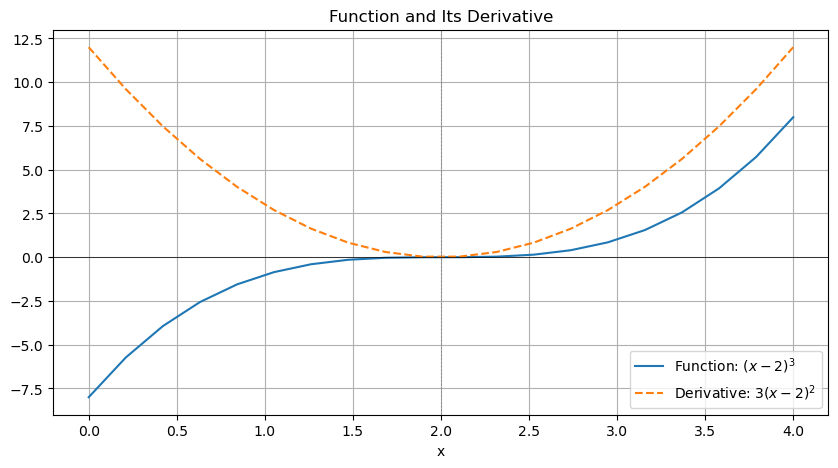

In [3]:
x = torch.linspace(0, 4, 20, requires_grad = True)
#print(x)
y = (x-2)  ** 3

# y.detach() shares the same data as y, 
#  it is detached from computational graph with no grad requirement; enabling us to plot it
y_detached = y.detach()
print(f"Type of y: {type(y)}")
print(f"Type of y_detached: {type(y_detached)}")
#plt.plot(y) #-> it won't work because the tensor y has grad attribute
#plt.plot(y_detached) #it works like a numpy array
x_detached = x.detach()

#backward() is only defined for scalar outputs
#interpret this as y = (x_1-2)^3 + (x_2-2)^3 + ....+(x_20-2)^3, where x_1 = 0 and x_20 = 4
z = torch.sum(y)
z.backward()

# Plot the function
plt.figure(figsize=(10, 5))
plt.plot(x_detached, y_detached, label='Function: $(x - 2)^3$')
# PLot the derivative
plt.plot(x_detached, x.grad.numpy(), label='Derivative: $3(x - 2)^2$', linestyle='--')


# Add labels and legend
plt.xlabel('x')
plt.title('Function and Its Derivative')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(2, color='grey', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()